In [22]:
%matplotlib inline
import os
import random
import json
import cPickle as pickle
import numpy as np
import matplotlib.pyplot
from matplotlib.pyplot import imshow
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model
from sklearn.decomposition import PCA
from scipy.spatial import distance
from tqdm import tqdm

In [2]:
model = keras.applications.VGG16(weights='imagenet', include_top=True)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [3]:
# get_image will return a handle to the image itself, and a numpy array of its pixels to input the network
def get_image(path):
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

def get_image_from_json_path(path):
    return os.path.join("../images/scaled", os.path.splitext(os.path.basename(path))[0] + ".jpg")

CPU times: user 1.44 s, sys: 166 ms, total: 1.6 s
Wall time: 752 ms
predicted jersey with probability 0.203
predicted web_site with probability 0.111
predicted power_drill with probability 0.074
predicted chain_saw with probability 0.060
predicted envelope with probability 0.054


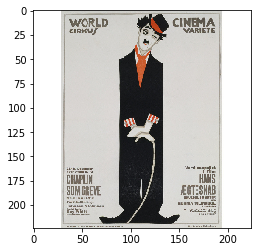

In [4]:
img, x = get_image("../images/scaled/8586b0281be4a8e6f18cee41135db9e2.jpg")
%time predictions = model.predict(x)
imshow(img)
for pred in decode_predictions(predictions)[0]:
    print("predicted %s with probability %0.3f" % (pred[1], pred[2]))

CPU times: user 1.36 s, sys: 115 ms, total: 1.48 s
Wall time: 592 ms
predicted apron with probability 0.345
predicted brassiere with probability 0.135
predicted book_jacket with probability 0.106
predicted web_site with probability 0.071
predicted jersey with probability 0.049


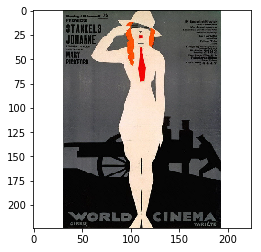

In [5]:
img, x = get_image("../images/scaled/515d18809f5b4de9f7018b216349e56a.jpg")
%time predictions = model.predict(x)
imshow(img)
for pred in decode_predictions(predictions)[0]:
    print("predicted %s with probability %0.3f" % (pred[1], pred[2]))

In [6]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
feat_extractor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

CPU times: user 1.39 s, sys: 59.6 ms, total: 1.45 s
Wall time: 602 ms


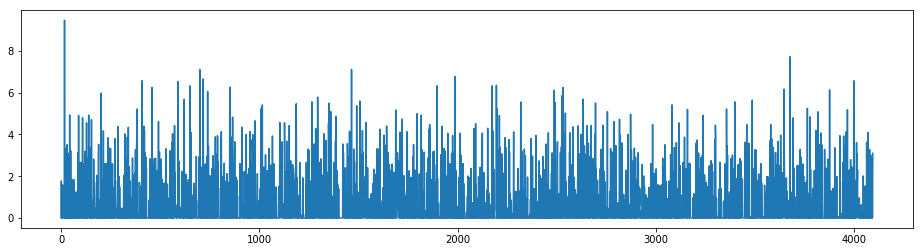

In [7]:
img, x = get_image("../images/scaled/515d18809f5b4de9f7018b216349e56a.jpg")
%time feat = feat_extractor.predict(x)

matplotlib.pyplot.figure(figsize=(16,4))
matplotlib.pyplot.plot(feat[0])
matplotlib.pyplot.show()

In [8]:
images_path = '../images/scaled'
max_num_images = 10000

images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
if max_num_images < len(images):
    images = [images[i] for i in sorted(random.sample(xrange(len(images)), max_num_images))]

print("keeping %d images to analyze" % len(images))

keeping 2275 images to analyze


In [9]:
word_features = []
for image_path in tqdm(images):
    img, x = get_image(image_path);
    feat = feat_extractor.predict(x)[0]
    word_features.append(feat)

100%|██████████| 2275/2275 [25:50<00:00,  1.47it/s]


In [10]:
word_features[0]

array([0.       , 0.       , 1.2361219, ..., 0.       , 0.       ,
       0.       ], dtype=float32)

In [31]:
def n(norm_type, value, scale = 10.0):
    if (norm_type == "h"):
        return float(value)/360.0*scale
    elif (norm_type == "sv"):
        return float(value)/100.0*scale
    elif (norm_type == "rgb"):
        return float(value)/255.0*scale

# get_image will return a numpy array of its colors to input the network
def get_file_colors(path):
    with open(path, 'r') as f:
        j = json.load(f)
        colors = []
        for c in j['imgdata'][1]['clusters']['cluster']:
            f = float(c[0]['f'])
            r, g, b = n("rgb", c[1]['rgb'][0]['r']), n("rgb", c[1]['rgb'][0]['g']), n("rgb", c[1]['rgb'][0]['b'])
            hx = c[2]['hex'][0]['hex']
            h, s, v = n("h", c[3]['hsv'][0]['h']), n("sv", c[3]['hsv'][0]['s']), n("sv", c[3]['hsv'][0]['v'])
            colors.append([f, hx, r, g, b, h, s, v])
    return colors

In [32]:
json_path = '../output-colors'
paths_colors = []
for image_path in tqdm(images):
    file_path = os.path.join(json_path, os.path.splitext(os.path.split(images[0])[1])[0] + ".json")
    feat = get_file_colors(file_path);
    paths_colors.append([file_path,feat])

100%|██████████| 2275/2275 [00:08<00:00, 267.83it/s]


In [33]:
paths_colors[0]

['../output-colors/de45e828f983315577f773cd5fd57d97.json',
 [[0.512941,
   u'#467084',
   2.7450980392156863,
   4.392156862745098,
   5.176470588235294,
   5.527777777777779,
   4.699999999999999,
   5.2],
  [0.186471,
   u'#BDB4A7',
   7.411764705882353,
   7.058823529411765,
   6.549019607843137,
   0.9722222222222222,
   1.2,
   7.4],
  [0.158529,
   u'#937B6C',
   5.76470588235294,
   4.823529411764706,
   4.235294117647059,
   0.6388888888888888,
   2.7,
   5.8],
  [0.075882,
   u'#383B3B',
   2.196078431372549,
   2.3137254901960786,
   2.3137254901960786,
   5.388888888888888,
   0.6,
   2.3000000000000003],
  [0.066176,
   u'#798C91',
   4.745098039215686,
   5.490196078431373,
   5.686274509803921,
   5.305555555555555,
   1.6,
   5.699999999999999]]]

In [34]:
# gets all color values (minus hex) and builds a new weighted list for all images
def organize_features(paths_colors):
    files = zip(*paths_colors)[0]
    color_data = zip(*paths_colors)[1]
    features = []
    # apply scores to a file
    for index, f in tqdm(enumerate(files)):
        rgbhsv_list = []
        tmp_features = list(word_features[index])
        rgbhsv_all = zip(*color_data[index])[2:]
        c1, c2, c3, c4, c5 = zip(*rgbhsv_all)
        [rgbhsv_list.extend(c) for c in [c1, c2, c3, c4, c5]]
        tmp_features.extend(rgbhsv_list)
        features.append(tmp_features)
    return files, features

In [35]:
files, features = organize_features(paths_colors)

2275it [00:01, 1290.38it/s]


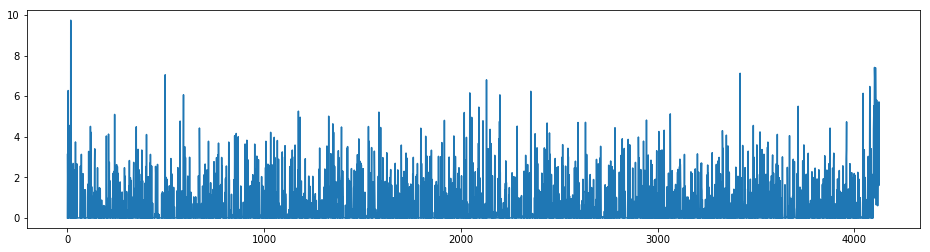

In [36]:
random_item = features[int(len(features) * random.random())]
matplotlib.pyplot.figure(figsize=(16,4))
matplotlib.pyplot.plot(random_item)
matplotlib.pyplot.show()

In [37]:
feature_values = np.array([x for x in features])
pca = PCA(n_components=30)
pca.fit(feature_values)
pca_features = pca.transform(feature_values)

In [38]:
def get_closest_images(query_image_idx, pca_features, num_results=5):
    distances = [ distance.euclidean(pca_features[query_image_idx], feat) for feat in pca_features ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    return idx_closest

def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        filename = images[idx]
        img = image.load_img(filename)
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image

Text(0.5,1,'result images')

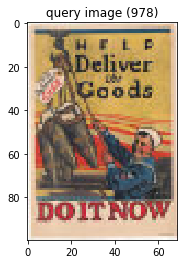

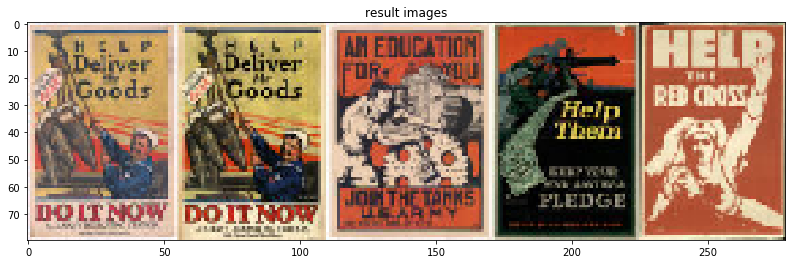

In [39]:
# do a query on a random image
query_image_idx = int(len(images) * random.random())
idx_closest = get_closest_images(query_image_idx, pca_features)
query_image = get_concatenated_images([query_image_idx], 100)
results_image = get_concatenated_images(idx_closest, 80)

# display the query image
matplotlib.pyplot.figure(figsize = (6,4))
imshow(query_image)
matplotlib.pyplot.title("query image (%d)" % query_image_idx)

# display the resulting images
matplotlib.pyplot.figure(figsize = (16,4))
imshow(results_image)
matplotlib.pyplot.title("result images")

In [40]:
matplotlib.pyplot.imsave("../output-ml4a/colors-v4-nearest-source.png", query_image)
matplotlib.pyplot.imsave("../output-ml4a/colors-v4-nearest.png", results_image)

In [41]:
pickle.dump([images, pca_features], open('../output-ml4a/colors-v4-features.p', 'wb'))

In [42]:
feature_values2 = np.array([x for x in features])
pca2 = PCA(n_components=3)
pca2.fit(feature_values2)
pca_features2 = pca2.transform(feature_values2)

Text(0.5,1,'result images')

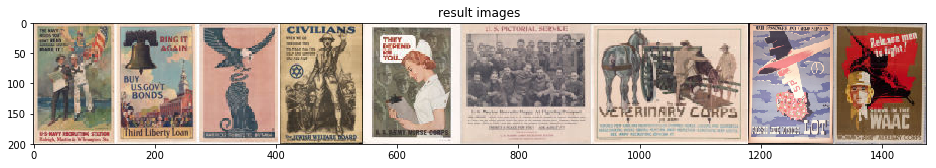

In [43]:
def get_image_path_between(query_image_idx_1, query_image_idx_2, pca_features, num_hops=4):
    path = [query_image_idx_1, query_image_idx_2]
    for hop in range(num_hops-1):
        t = float(hop+1) / num_hops
        lerp_acts = t * pca_features[query_image_idx_1] + (1.0-t) * pca_features[query_image_idx_2]
        distances = [distance.euclidean(lerp_acts, feat) for feat in pca_features]
        idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])
        path.insert(1, [i for i in idx_closest if i not in path][0])
    return path

# pick image and number of hops
num_hops = 8
query_image_idx_1 = int(len(images) * random.random())
query_image_idx_2 = int(len(images) * random.random())

# get path
path = get_image_path_between(query_image_idx_1, query_image_idx_2, pca_features2, num_hops)

# draw image
path_image = get_concatenated_images(path, 200)
matplotlib.pyplot.figure(figsize = (16,12))
imshow(path_image)
matplotlib.pyplot.title("result images")

In [44]:
matplotlib.pyplot.imsave("../output-ml4a/colors-v4-path.png", path_image)

In [45]:
from sklearn.manifold import TSNE
from PIL import Image

In [46]:
images, pca_features = pickle.load(open('../output-ml4a/colors-v4-features.p', 'r'))

for i, f in zip(images, pca_features)[0:5]:
    print("image: %s, features: %0.2f,%0.2f,%0.2f,%0.2f... "%(i, f[0], f[1], f[2], f[3]))

image: ../images/scaled/de45e828f983315577f773cd5fd57d97.jpg, features: -9.64,-17.49,-3.59,4.11... 
image: ../images/scaled/071d0bdbc6c5a7e9407c8d4609659d7f.jpg, features: -28.65,12.74,0.01,14.12... 
image: ../images/scaled/f9dd4da3049ae2d2294d382c73263b01.jpg, features: 3.01,-25.20,6.25,8.84... 
image: ../images/scaled/83c3bc6451179acf881583c43cb5b230.jpg, features: -11.22,5.93,13.46,-1.40... 
image: ../images/scaled/e14208b8b8dac90760589e5a63baab84.jpg, features: -17.08,-4.68,0.25,-20.71... 


In [47]:
X = np.array(pca_features)
tsne = TSNE(n_components=2, learning_rate=150, perplexity=30, angle=0.2, verbose=2).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2275 samples in 0.010s...
[t-SNE] Computed neighbors for 2275 samples in 0.461s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2275
[t-SNE] Computed conditional probabilities for sample 2000 / 2275
[t-SNE] Computed conditional probabilities for sample 2275 / 2275
[t-SNE] Mean sigma: 10.601992
[t-SNE] Computed conditional probabilities in 0.123s
[t-SNE] Iteration 50: error = 79.8264465, gradient norm = 0.0134855 (50 iterations in 9.943s)
[t-SNE] Iteration 100: error = 79.8227921, gradient norm = 0.0090754 (50 iterations in 8.844s)
[t-SNE] Iteration 150: error = 79.5404282, gradient norm = 0.0076823 (50 iterations in 4.632s)
[t-SNE] Iteration 200: error = 79.5334320, gradient norm = 0.0053210 (50 iterations in 4.461s)
[t-SNE] Iteration 250: error = 79.5329895, gradient norm = 0.0043961 (50 iterations in 4.225s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.532990
[t-SNE] Iteration 300: err

In [48]:
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

100%|██████████| 2275/2275 [00:16<00:00, 140.12it/s]


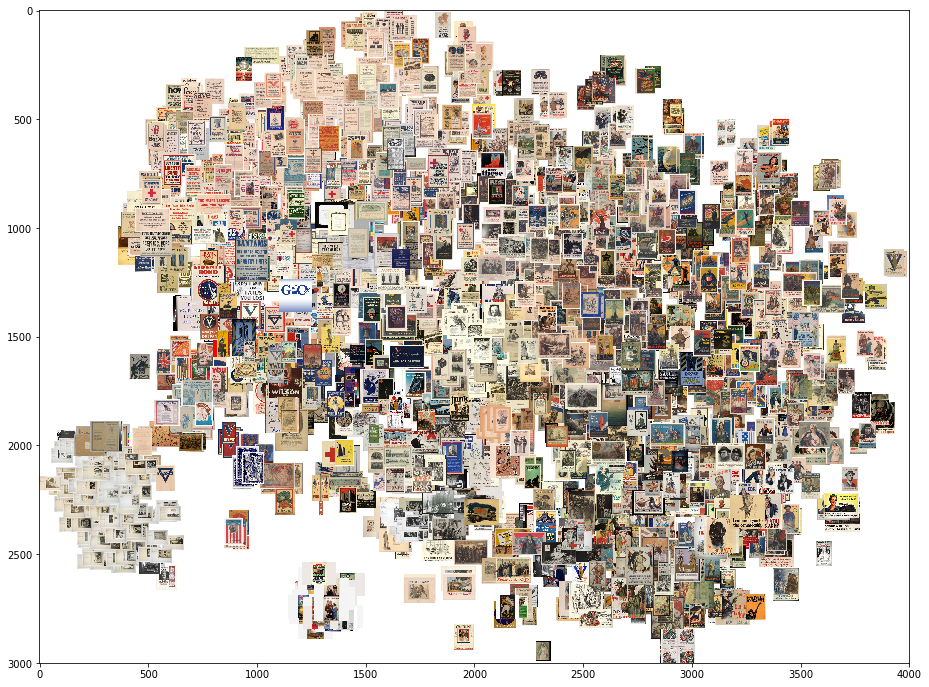

In [49]:
width = 4000
height = 3000
max_dim = 100

full_image = Image.new('RGBA', (width, height))
for img, x, y in tqdm(zip(images, tx, ty)):
    tile = Image.open(get_image_from_json_path(img))
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(full_image)

In [50]:
full_image.save("../output-ml4a/colors-v4-tSNE.png")

In [51]:
tsne_path = "../output-ml4a/colors-v4-tSNE-points.json"

data = [{"path":os.path.abspath(img), "point":[float(x), float(y)]} for img, x, y in zip(images, tx, ty)]
with open(tsne_path, 'w') as outfile:
    json.dump(data, outfile)

print("saved t-SNE result to %s" % tsne_path)

saved t-SNE result to ../output-ml4a/colors-v4-tSNE-points.json


In [52]:
import rasterfairy

# nx * ny ≈ the number of images
nx = 53
ny = 43

# assign to grid
%time grid_assignment = rasterfairy.transformPointCloud2D(tsne, target=(nx, ny))

CPU times: user 28.4 ms, sys: 3.3 ms, total: 31.7 ms
Wall time: 69 ms


In [53]:
tile_width = 60
tile_height = 80

full_width = tile_width * nx
full_height = tile_height * ny
aspect_ratio = float(tile_width) / tile_height

grid_image = Image.new('RGB', (full_width, full_height))

for img, grid_pos in tqdm(zip(images, grid_assignment[0])):
    idx_x, idx_y = grid_pos
    x, y = tile_width * idx_x, tile_height * idx_y
    tile = Image.open(get_image_from_json_path(img))
    tile_ar = float(tile.width) / tile.height  # center-crop the tile to match aspect_ratio
    if (tile_ar > aspect_ratio):
        margin = 0.5 * (tile.width - aspect_ratio * tile.height)
        tile = tile.crop((margin, 0, margin + aspect_ratio * tile.height, tile.height))
    else:
        margin = 0.5 * (tile.height - float(tile.width) / aspect_ratio)
        tile = tile.crop((0, margin, tile.width, margin + float(tile.width) / aspect_ratio))
    tile = tile.resize((tile_width, tile_height), Image.ANTIALIAS)
    grid_image.paste(tile, (int(x), int(y)))

100%|██████████| 2275/2275 [00:14<00:00, 154.22it/s]


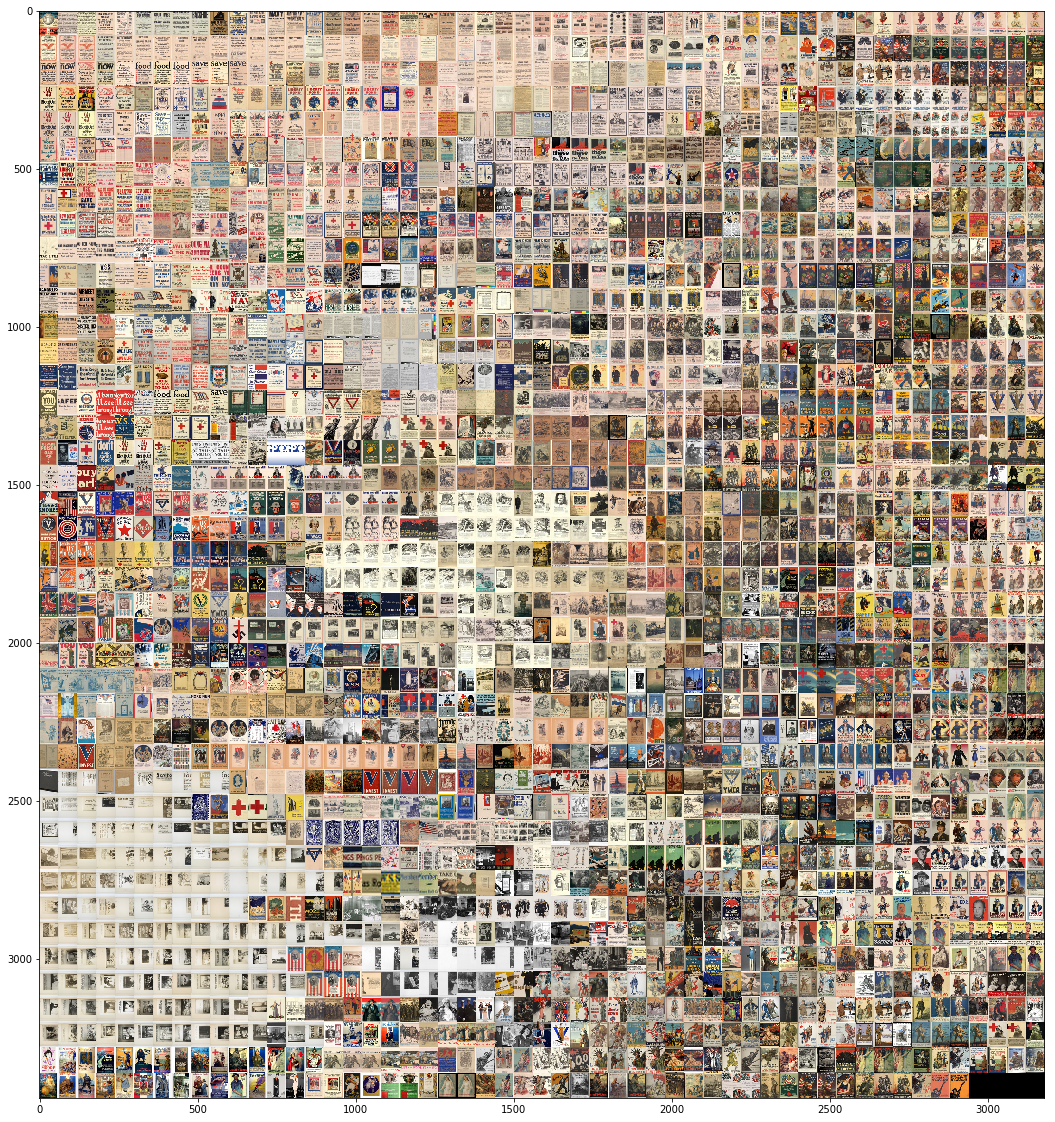

In [54]:
matplotlib.pyplot.figure(figsize = (20,20))
imshow(grid_image)

In [55]:
grid_image.save("../output-ml4a/colors-v4-tSNE-grid.jpg")

In [56]:
grid_path = "../output-ml4a/colors-v4-tSNE-grid-points.json"

data = [{"path":os.path.abspath(img), "point":[float(x), float(y)]} for img, x, y in zip(images, grid_assignment[0][0:,0], grid_assignment[0][0:,1])]
with open(grid_path, 'w') as outfile:
    json.dump(data, outfile)

print("saved rasterfairy grid to %s" % grid_path)

saved rasterfairy grid to ../output-ml4a/colors-v4-tSNE-grid-points.json
